In [1]:
!pip install -U -q pyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# https://drive.google.com/file/d/15cKvGkTw0EWkxD5albvMQRsiRl4FIYl8/view?usp=drive_link
id = "15cKvGkTw0EWkxD5albvMQRsiRl4FIYl8"
file = drive.CreateFile({'id': id})
file.GetContentFile('loan-clean-version.csv')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go

from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, roc_curve, auc

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

In [4]:
lc_df = pd.read_csv('loan-clean-version.csv')
lc_df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,...,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,loan_status
0,1077501,5000,5000,4975.0,36 months,10.65,162.87,B,10+ years,RENT,...,13648,83.7,9,0,0,5861.071414,5831.78,5000.00,861.07,Fully Paid
1,1077430,2500,2500,2500.0,60 months,15.27,59.83,C,Less than 1 year,RENT,...,1687,9.4,4,0,0,1008.710000,1008.71,456.46,435.17,Charged Off
2,1077175,2400,2400,2400.0,36 months,15.96,84.33,C,10+ years,RENT,...,2956,98.5,10,0,0,3003.653644,3003.65,2400.00,603.65,Fully Paid
3,1076863,10000,10000,10000.0,36 months,13.49,339.31,C,10+ years,RENT,...,5598,21.0,37,0,0,12226.302210,12226.30,10000.00,2209.33,Fully Paid
4,1075269,5000,5000,5000.0,36 months,7.90,156.46,A,3 years,RENT,...,7963,28.3,12,0,0,5631.377753,5631.38,5000.00,631.38,Fully Paid


# Part 1: Data Exploration

In [5]:
lc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9004 entries, 0 to 9003
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   9004 non-null   int64  
 1   loan_amnt            9004 non-null   int64  
 2   funded_amnt          9004 non-null   int64  
 3   funded_amnt_inv      9004 non-null   float64
 4   term                 9004 non-null   object 
 5   int_rate             9004 non-null   float64
 6   installment          9004 non-null   float64
 7   grade                9004 non-null   object 
 8   emp_length           8688 non-null   object 
 9   home_ownership       9004 non-null   object 
 10  annual_inc           9004 non-null   float64
 11  verification_status  9004 non-null   object 
 12  purpose              9004 non-null   object 
 13  addr_state           9004 non-null   object 
 14  dti                  9004 non-null   float64
 15  earliest_cr_line     9004 non-null   i

In [6]:
# Check unique vals of each col
lc_df.nunique()

,0
id,9004
loan_amnt,604
funded_amnt,681
funded_amnt_inv,1234
term,2
int_rate,70
installment,3871
grade,7
emp_length,11
home_ownership,3


In [7]:
# Check missing vals
lc_df.isnull().sum()

,0
id,0
loan_amnt,0
funded_amnt,0
funded_amnt_inv,0
term,0
int_rate,0
installment,0
grade,0
emp_length,316
home_ownership,0


In [8]:
lc_df.loc[:, 'loan_status'].value_counts()

,count
loan_status,
Fully Paid,7487
Charged Off,1517


In [9]:
num_cols = lc_df.columns[lc_df.dtypes != 'object']
cat_cols = lc_df.columns[lc_df.dtypes == 'object']
len(num_cols), len(cat_cols)

(21, 8)

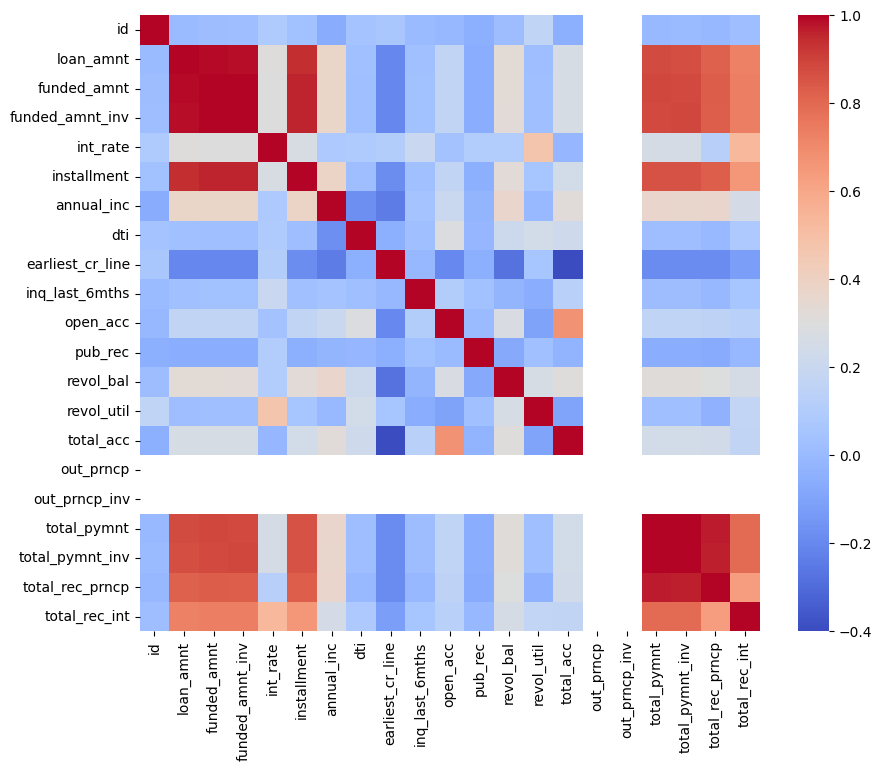

In [10]:
corr = lc_df[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm')
plt.show()

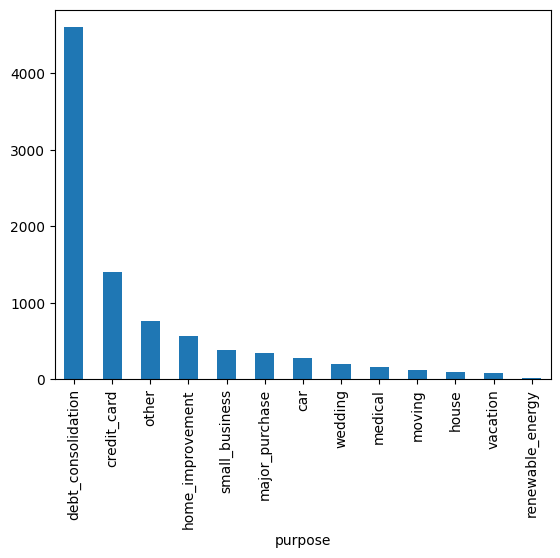

In [11]:
lc_df['purpose'].value_counts().plot(kind='bar')
plt.show()

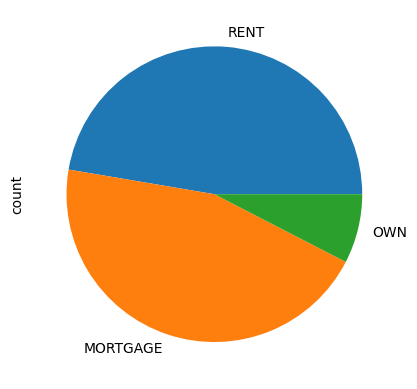

In [12]:
lc_df['home_ownership'].value_counts().plot(kind='pie')
plt.show()

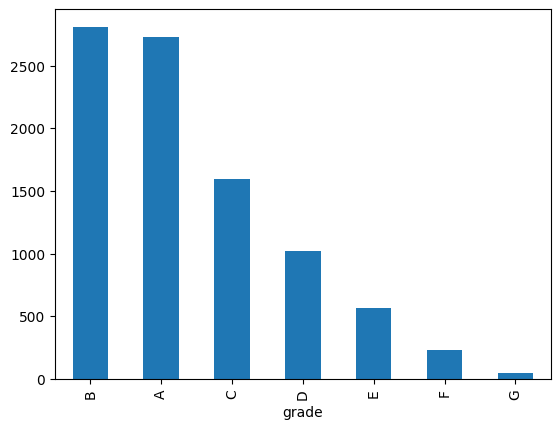

In [13]:
lc_df['grade'].value_counts().plot(kind='bar')
plt.show()

In [14]:
# Total loan ammount and annual income by state
df_loc = lc_df.groupby('addr_state')[['loan_amnt', 'annual_inc']].sum().reset_index()
df_loc.head()

,addr_state,loan_amnt,annual_inc
0,AK,359675,1.396272e+06
1,AL,1308425,6.505896e+06
2,AR,753275,3.585238e+06
3,AZ,2477200,1.401643e+07
4,CA,20470425,1.193732e+08


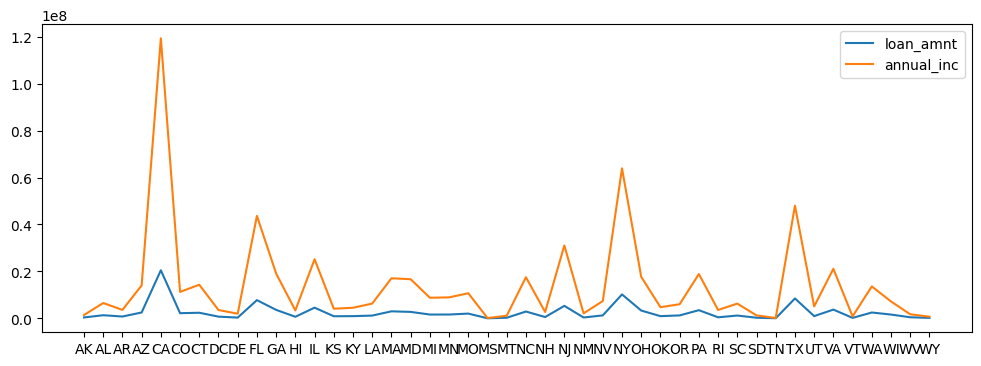

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(df_loc['addr_state'], df_loc['loan_amnt'])
plt.plot(df_loc['addr_state'], df_loc['annual_inc'])
plt.legend(['loan_amnt', 'annual_inc'])
plt.show()
# df_loc['loan_amnt'].plot(kind='line', figsize=(8, 4), legend='loan_amnt')
# df_loc['annual_inc'].plot(kind='line', figsize=(8, 4), legend='annual_inc')
# plt.show()

In [16]:
fig = go.Figure(go.Choropleth(locations=df_loc['addr_state'], z=df_loc['loan_amnt'], locationmode='USA-states'))
fig.update_layout(title_text='Total Loan Amount by State', geo_scope='usa')
fig.show()

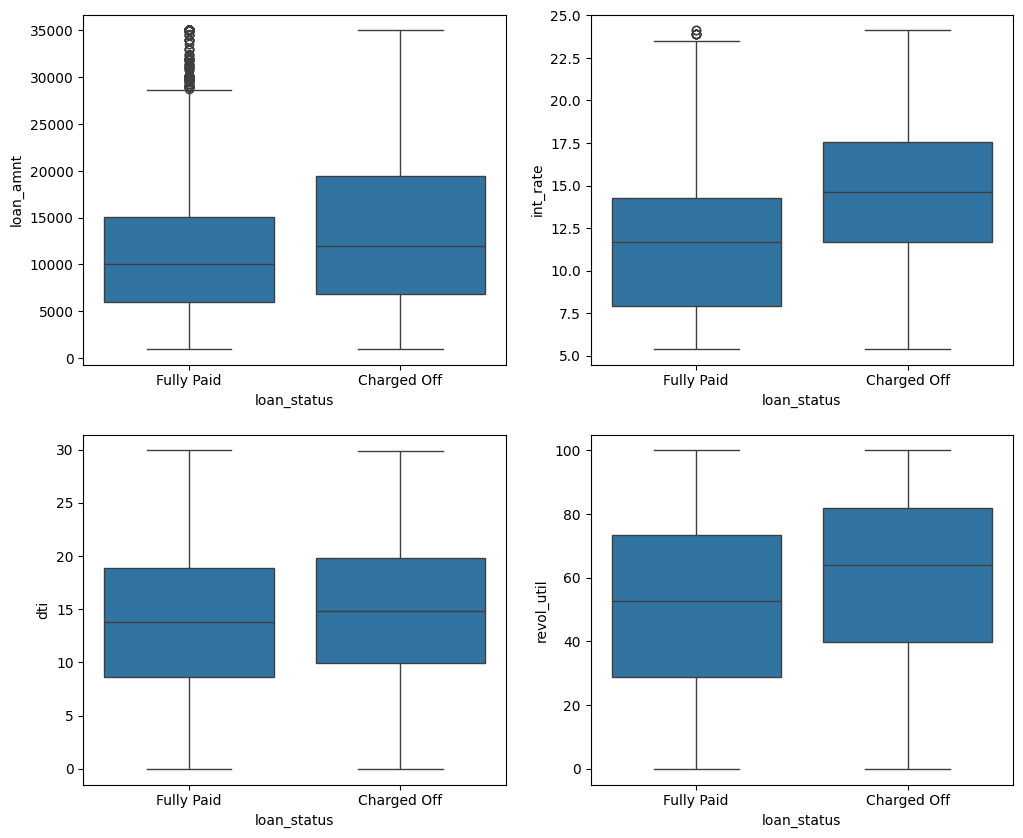

In [17]:
# Boxplot for some numerical features
_, axss = plt.subplots(2, 2, figsize=(12, 10))
sns.boxplot(ax=axss[0, 0], data=lc_df, x='loan_status', y='loan_amnt')
sns.boxplot(ax=axss[0, 1], data=lc_df, x='loan_status', y='int_rate')
sns.boxplot(ax=axss[1, 0], data=lc_df, x='loan_status', y='dti')
sns.boxplot(ax=axss[1, 1], data=lc_df, x='loan_status', y='revol_util')
plt.show()

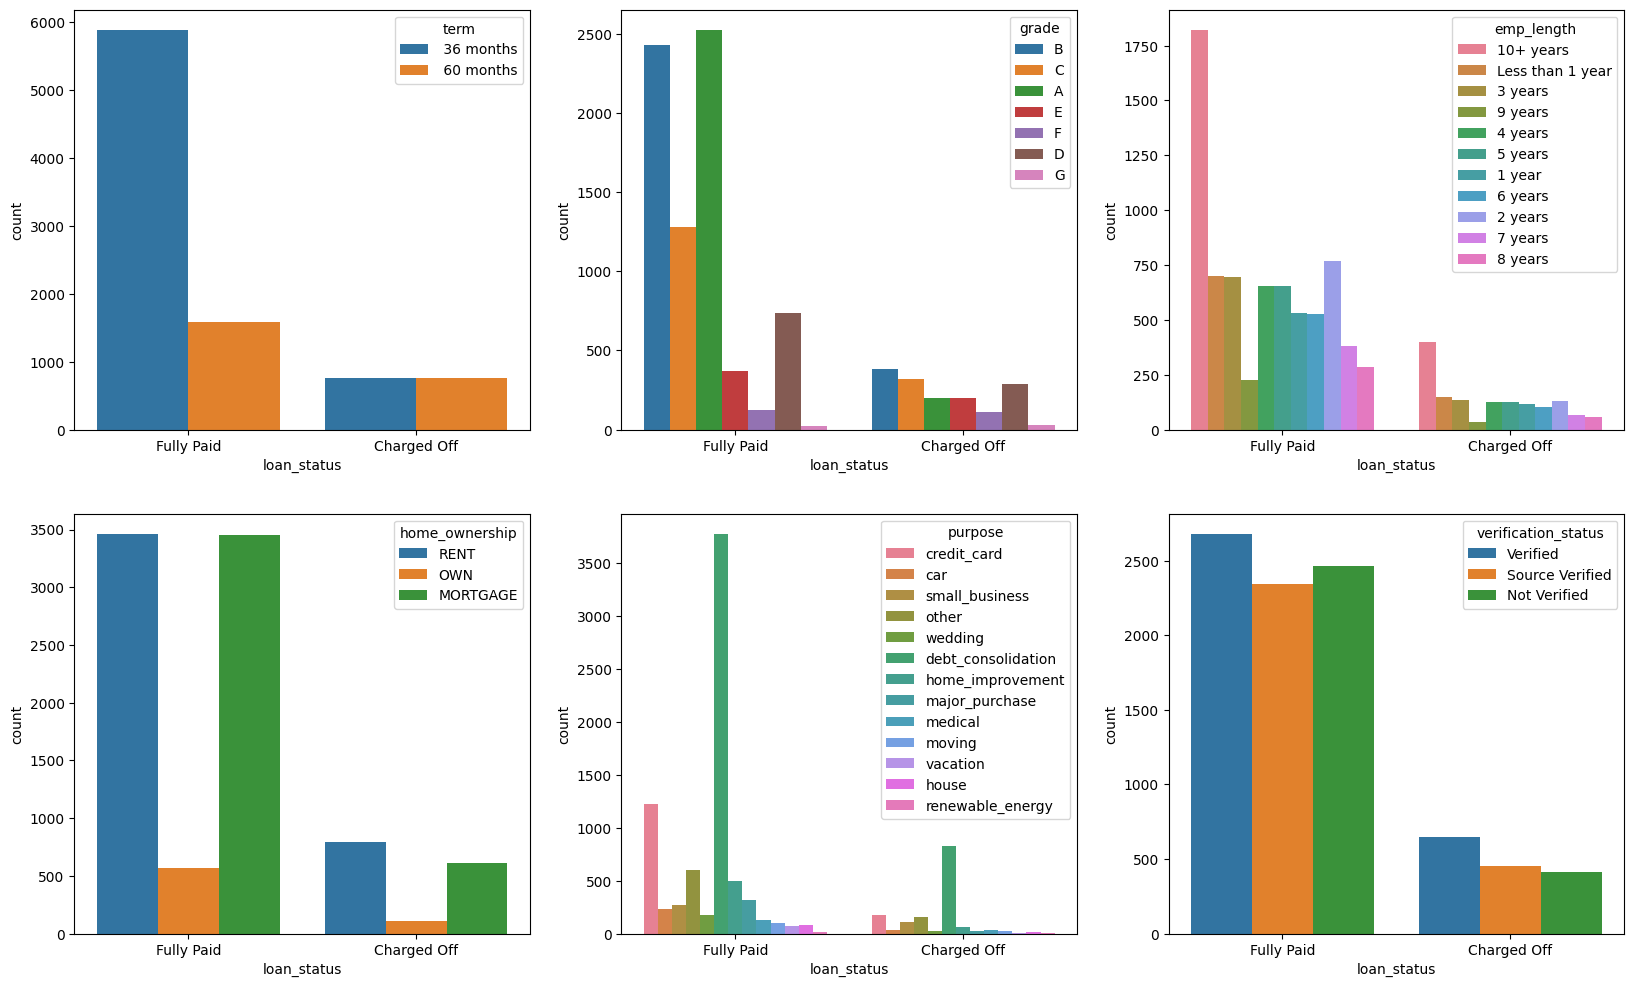

In [18]:
# Explore categorical features
_, axss = plt.subplots(2, 3, figsize=(20, 12))
sns.countplot(ax=axss[0, 0], data=lc_df, hue='term', x='loan_status')
sns.countplot(ax=axss[0, 1], data=lc_df, hue='grade', x='loan_status')
sns.countplot(ax=axss[0, 2], data=lc_df, hue='emp_length', x='loan_status')
sns.countplot(ax=axss[1, 0], data=lc_df, hue='home_ownership', x='loan_status')
sns.countplot(ax=axss[1, 1], data=lc_df, hue='purpose', x='loan_status')
sns.countplot(ax=axss[1, 2], data=lc_df, hue='verification_status', x='loan_status')
plt.show()

# Part 2: Data Cleaning and Preprocessing

In [19]:
y = lc_df['loan_status']

class_mapping = {'Fully Paid' : 0, 'Charged Off' : 1}
y = y.map(class_mapping)

# Drop features with high correlations, high variance and data leakage
X = lc_df.drop(columns=['loan_status', 'emp_length', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_prncp', 'id'])

In [20]:
categories = ['term', 'grade', 'home_ownership', 'purpose', 'verification_status', 'addr_state']
enc_oe = OrdinalEncoder()
enc_oe.fit(X[categories])
X[categories] = enc_oe.transform(X[categories])

# Deal with missing data
X = X.interpolate().dropna()
X.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv
0,5000,5000,4975.0,0.0,10.65,162.87,1.0,2.0,24000.0,2.0,...,27.65,31048,1,3,0,13648,83.7,9,0,0
1,2500,2500,2500.0,1.0,15.27,59.83,2.0,2.0,30000.0,1.0,...,1.00,36251,5,3,0,1687,9.4,4,0,0
2,2400,2400,2400.0,0.0,15.96,84.33,2.0,2.0,12252.0,0.0,...,8.72,43040,2,2,0,2956,98.5,10,0,0
3,10000,10000,10000.0,0.0,13.49,339.31,2.0,2.0,49200.0,1.0,...,20.00,35096,1,10,0,5598,21.0,37,0,0
4,5000,5000,5000.0,0.0,7.90,156.46,0.0,2.0,36000.0,1.0,...,11.20,43043,3,9,0,7963,28.3,12,0,0


In [21]:
# Split into trainging and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)
print('Train set: ', X_train.shape, y_train.shape)
print('Test set: ', X_test.shape, y_test.shape)

Train set:  (6753, 22) (6753,)
Test set:  (2251, 22) (2251,)


In [22]:
X_train.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,...,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv
7442,14400,14400,14400.0,1.0,19.29,375.85,4.0,1.0,150000.0,1.0,...,4.88,43009,1,8,0,3859,52.8,26,0,0
8145,7000,7000,7000.0,0.0,5.42,211.12,0.0,1.0,45000.0,1.0,...,7.36,42738,0,8,0,11237,68.9,16,0,0
1434,1325,1325,1325.0,0.0,6.62,40.69,0.0,1.0,39456.0,0.0,...,26.22,36557,1,9,0,10791,43.8,29,0,0
2777,12000,12000,12000.0,0.0,6.62,368.45,0.0,2.0,60000.0,0.0,...,8.86,36161,1,9,0,10170,23.8,29,0,0
1867,16000,16000,15975.0,1.0,15.27,382.92,2.0,0.0,45200.0,2.0,...,19.67,33482,3,7,0,14750,58.5,17,0,0


In [23]:
# Standardize / Normalize Data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Model Training and Result Evaluation

In [24]:
# Logistic Regression
classifier_logistic = LogisticRegression()
classifier_logistic.fit(X_train, y_train)

# KNN
classifier_KNN = KNeighborsClassifier()
classifier_KNN.fit(X_train, y_train)

# Random Forest
classifier_RF = RandomForestClassifier()
classifier_RF.fit(X_train, y_train)

# SVC
classifier_SVC = SVC()
classifier_SVC.fit(X_train, y_train)

# MLP
classifier_MLP = MLPClassifier(hidden_layer_sizes=(30,30,30))
classifier_MLP.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPClassifier(hidden_layer_sizes=(30, 30, 30))

In [25]:
# Prediction of test data
y_pred_logistic = classifier_logistic.predict(X_test)
y_pred_knn = classifier_KNN.predict(X_test)
y_pred_RF = classifier_RF.predict(X_test)
y_pred_SVC = classifier_SVC.predict(X_test)
y_pred_MLP = classifier_MLP.predict(X_test)

In [26]:
print('Logisc Regression Report: ')
print(classification_report(y_test, y_pred_logistic))
print()
print('KNN Report: ')
print(classification_report(y_test, y_pred_knn))
print()
print('Random Forest Report: ')
print(classification_report(y_test, y_pred_RF))
print()
print('SVC Report: ')
print(classification_report(y_test, y_pred_SVC))
print()
print('MLP Report: ')
print(classification_report(y_test, y_pred_MLP))

Logisc Regression Report: 
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1872
           1       0.64      0.06      0.10       379

    accuracy                           0.84      2251
   macro avg       0.74      0.52      0.51      2251
weighted avg       0.80      0.84      0.77      2251


KNN Report: 
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1872
           1       0.43      0.15      0.22       379

    accuracy                           0.82      2251
   macro avg       0.64      0.55      0.56      2251
weighted avg       0.78      0.82      0.79      2251


Random Forest Report: 
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1872
           1       0.69      0.08      0.14       379

    accuracy                           0.84      2251
   macro avg       0.77      0.53      0.52      2251
weighted 

In [27]:
# Cross validation (5-fold)
cv_logistic = cross_val_score(classifier_logistic, X_train, y_train, cv=5)
cv_KNN = cross_val_score(classifier_KNN, X_train, y_train, cv=5)
cv_RF = cross_val_score(classifier_RF, X_train, y_train, cv=5)
cv_SVC = cross_val_score(classifier_SVC, X_train, y_train, cv=5)
cv_MLP = cross_val_score(classifier_MLP, X_train, y_train, cv=5)
print('Logistic Regression: ')
print('Cross Validation: ', cv_logistic)
print('Accuracy: ', cv_logistic.mean())
print()
print('KNN: ')
print('Cross Validation: ', cv_KNN)
print('Accuracy: ', cv_KNN.mean())
print()
print('Random Forest: ')
print('Cross Validation: ', cv_RF)
print('Accuracy: ', cv_RF.mean())
print()
print('SVC: ')
print('Cross Validation: ', cv_SVC)
print('Accuracy: ', cv_SVC.mean())
print()
print('MLP: ')
print('Cross Validation: ', cv_MLP)
print('Accuracy: ', cv_MLP.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



Logistic Regression: 
Cross Validation:  [0.83641747 0.83271651 0.83641747 0.82666667 0.83851852]
Accuracy:  0.8341473257120926

KNN: 
Cross Validation:  [0.80977054 0.80754996 0.80977054 0.80148148 0.81555556]
Accuracy:  0.8088256161416784

Random Forest: 
Cross Validation:  [0.83641747 0.82827535 0.82753516 0.82740741 0.8362963 ]
Accuracy:  0.8311863365956629

SVC: 
Cross Validation:  [0.83123612 0.83197631 0.83197631 0.83185185 0.83259259]
Accuracy:  0.8319266387038409

MLP: 
Cross Validation:  [0.80754996 0.803849   0.79792746 0.79037037 0.80962963]
Accuracy:  0.8018652849740932


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



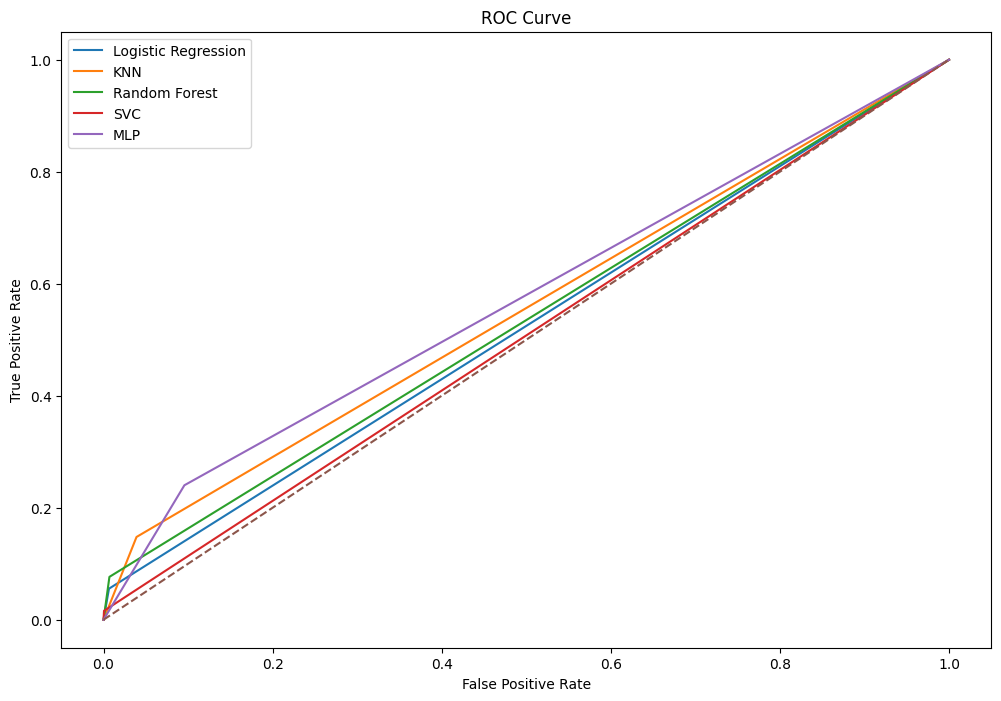

In [28]:
roc_logistic = roc_curve(y_test, y_pred_logistic)
roc_knn = roc_curve(y_test, y_pred_knn)
roc_RF = roc_curve(y_test, y_pred_RF)
roc_SVC = roc_curve(y_test, y_pred_SVC)
roc_MLP = roc_curve(y_test, y_pred_MLP)

plt.figure(figsize=(12, 8))
plt.plot(roc_logistic[0], roc_logistic[1], label='Logistic Regression')
plt.plot(roc_knn[0], roc_knn[1], label='KNN')
plt.plot(roc_RF[0], roc_RF[1], label='Random Forest')
plt.plot(roc_SVC[0], roc_SVC[1], label='SVC')
plt.plot(roc_MLP[0], roc_MLP[1], label='MLP')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [29]:
auc_logistic = auc(roc_logistic[0], roc_logistic[1])
auc_knn = auc(roc_knn[0], roc_knn[1])
auc_rf = auc(roc_RF[0], roc_RF[1])
auc_SVC = auc(roc_SVC[0], roc_SVC[1])
auc_MLP = auc(roc_MLP[0], roc_MLP[1])
print('Logistic Regression AUC: ', auc_logistic)
print('KNN AUC: ', auc_knn)
print('Random Forest AUC: ', auc_rf)
print('SVC AUC: ', auc_SVC)
print('MLP AUC: ', auc_MLP)

Logistic Regression AUC:  0.5244993572829985
KNN AUC:  0.5543807647204746
Random Forest AUC:  0.534786352975667
SVC AUC:  0.5076484732652279
MLP AUC:  0.5722429413887198


# Feature Importance

In [45]:
rf = RandomForestClassifier()
rf.fit(X, y)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature importance ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s: %f" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature importance ranking:
1. feature annual_inc: 0.080607
2. feature revol_util: 0.079398
3. feature int_rate: 0.078634
4. feature dti: 0.075574
5. feature revol_bal: 0.075275
6. feature earliest_cr_line: 0.074697
7. feature installment: 0.064352
8. feature total_acc: 0.060914
9. feature funded_amnt_inv: 0.053650
10. feature addr_state: 0.053195
11. feature open_acc: 0.048207
12. feature funded_amnt: 0.045853
13. feature loan_amnt: 0.045145
14. feature purpose: 0.035239
15. feature grade: 0.032508
16. feature term: 0.030527
17. feature inq_last_6mths: 0.025565
18. feature verification_status: 0.017923
19. feature home_ownership: 0.016012
20. feature pub_rec: 0.006724
21. feature out_prncp: 0.000000
22. feature out_prncp_inv: 0.000000


# Others


In [36]:
def print_grid_search_metrics(gs):
  print('Best score: ' + str(gs.best_score_))
  print('Best parameters set: ')
  best_parameters = gs.best_params_
  for param_name in sorted(best_parameters.keys()):
    print('\t%s: %r' % (param_name, best_parameters[param_name]))

In [39]:
parameters_logistic = {'penalty': ('l1', 'l2'), 'C': (0.001, 0.01, 0.1, 1, 10, 100, 1000)}
Grid_logistic = GridSearchCV(LogisticRegression(solver='liblinear'), parameters_logistic, cv=5)
Grid_logistic.fit(X_train, y_train)
print_grid_search_metrics(Grid_logistic)

Best score: 0.8347396989884036
Best parameters set: 
	C: 0.1
	penalty: 'l2'


In [42]:
best_LR_model = Grid_logistic.best_estimator_
best_LR_model.predict(X_test)
best_LR_model.score(X_test, y_test)

0.8351843625055531

In [46]:
best_LR_model.fit(X, y)
indices = np.argsort(best_LR_model.coef_[0])[::-1]
print("Feature importance ranking:")
for f in range(X.shape[1]):
    print("%d. feature %s: %f" % (f + 1, X.columns[indices[f]], best_LR_model.coef_[0][indices[f]]))

Feature importance ranking:
1. feature int_rate: 0.069803
2. feature grade: 0.025446
3. feature purpose: 0.019992
4. feature open_acc: 0.009255
5. feature inq_last_6mths: 0.008822
6. feature revol_util: 0.008385
7. feature term: 0.004876
8. feature home_ownership: 0.003048
9. feature pub_rec: 0.000948
10. feature funded_amnt_inv: 0.000073
11. feature funded_amnt: 0.000055
12. feature loan_amnt: 0.000026
13. feature out_prncp: 0.000000
14. feature out_prncp_inv: 0.000000
15. feature revol_bal: -0.000006
16. feature annual_inc: -0.000011
17. feature earliest_cr_line: -0.000059
18. feature verification_status: -0.000228
19. feature dti: -0.002919
20. feature installment: -0.004711
21. feature addr_state: -0.005360
22. feature total_acc: -0.010150
